In [21]:
data = np.random.randint(0, 255, (8, 2, 512, 512, 3), 'uint8')
subresolutions = 2
pixelsize = 0.29  # micrometer

In [23]:
data.shape

(8, 2, 512, 512, 3)

In [2]:
from dask_image import imread
import skimage.io as io
import dask.array as da
from scipy.ndimage import zoom
from math import ceil
import numpy as np
import tifffile

def rescale_block(block, factors):
    return zoom(block, factors, order=3)  # Cubic interpolation

def downscale_dask(dask_array, factors=(1, 0.5, 0.5)):
    assert len(factors) == len(dask_array.shape), f"The length of `factors` {factors} {len(factors)} must match the number of dimensions in `dask_array` {dask_array.shape} {len(dask_array.shape)}."
    
    new_shape = tuple(ceil(s * f) for s, f in zip(dask_array.shape, factors))
    new_chunks = tuple(min(ceil(c * f), ns) for c, f, ns in zip(dask_array.chunksize, factors, new_shape))
    
    return dask_array.map_blocks(
        rescale_block,
        factors=factors,
        dtype=dask_array.dtype,
        chunks=new_chunks
    )

In [24]:
def metadata_parse(img):
    omexml = tifffile.OmeXml()
    omexml.addimage(
        dtype=img.dtype, shape=img.shape, axes='CYX',
        storedshape=(img.shape[0], 1, 1, img.shape[1], img.shape[2], 1))
    omexml = omexml.tostring()
    return omexml

In [28]:
xy = [45000,55000]

In [31]:
max(xy)

55000

In [32]:
max(xy)/1072

51.30597014925373

In [33]:
max(1,max(xy)/1072)

51.30597014925373

In [34]:
np.log2(max(1, max(xy) / 1072))

np.float64(5.681054807728974)

In [35]:
np.ceil(np.log2(max(1, max(xy) / 1072))) + 1

np.float64(7.0)

In [30]:
subifds = (np.ceil(np.log2(max(1, max(xy) / 1072))) + 1).astype(int)
subifds

np.int64(7)

In [27]:
im = imread.imread("/Volumes/RD_Coscia/Jose/Resources/TestDatasets/TD_03_Exemplar001.ome.tif")
nchannels = im.shape[0]
ome_xml = metadata_parse(im)
subifds = 3

with tifffile.TiffWriter('test_3levels.ome.tif', ome=False, bigtiff=True) as tif:
    for channel_idx in range(nchannels):
        tif.write(
            im[channel_idx, :, :],
            description=ome_xml,
            subifds=subifds,
            metadata=False,  # do not write tifffile metadata
            tile=(256, 256),
            photometric='minisblack',
        )

        for i in range(subifds):
            res = 2 ** (i + 1)
            tif.write(
                im[channel_idx, ::res, ::res],  # in production use resampling
                subfiletype=1,
                metadata=False,
                tile=(256, 256),
                photometric='minisblack',
            )

In [ ]:
image = tifffile.imread("/Volumes/RD_Coscia/Jose/Resources/TestDatasets/TD_03_Exemplar001.ome.tif")

In [4]:
image.shape

(12, 3139, 2511)

In [5]:
type(image)

numpy.ndarray

In [6]:
image = imread.imread("/Volumes/RD_Coscia/Jose/Resources/TestDatasets/TD_03_Exemplar001.ome.tif")

In [8]:
image.shape

(12, 3139, 2511)

In [9]:
image.dtype

dtype('uint16')

In [14]:
image_params = set_parameters_from_image(image)

In [15]:
image_params

{'dtype': dtype('uint16'),
 'xy_shape': (3139, 2511),
 'num_channels': 12,
 'num_levels': np.int64(3),
 'factors': array([1, 2, 4]),
 'shapes': array([[3139, 2511],
        [1570, 1256],
        [ 785,  628]]),
 'cxy_shapes_all_levels': [(12, np.int64(3139), np.int64(2511)),
  (12, np.int64(1570), np.int64(1256)),
  (12, np.int64(785), np.int64(628))],
 'tip_level': np.int64(2),
 'tile_shapes': [(1072, 1072), (1072, 1072), (1072, 1072)]}

In [16]:
import ome_types
metadata = ome_types.from_tiff("/Volumes/RD_Coscia/Jose/Resources/TestDatasets/TD_03_Exemplar001.ome.tif")

In [17]:
metadata

OME(
   images=[<1 field_type>],
   uuid='urn:uuid:b413ac24-f26b-11ee-bbfa-0242ac110002',
   creator='Ashlar v1.17.0',
)

In [18]:
pixel_size = metadata.images[0].pixels.physical_size_x

In [19]:
pixel_size

0.6499999761581421

In [13]:
def set_parameters_from_image(image, tile_size=1072):
    """
    Set parameters for the image pyramid generation
    """
    image_parameters = {}
    image_parameters["dtype"] = image.dtype
    image_parameters["xy_shape"] = image.shape[-2:]
    image_parameters["num_channels"] = image.shape[0]
    image_parameters["num_levels"] = (np.ceil(np.log2(max(1, max(image_parameters["xy_shape"]) / tile_size))) + 1).astype(int)
    image_parameters["factors"] = 2 ** np.arange(image_parameters["num_levels"])
    image_parameters["shapes"] = (np.ceil(np.array(image_parameters["xy_shape"]) / image_parameters["factors"][:, None])).astype(int)
    image_parameters["cxy_shapes_all_levels"] = []
    for shape in image_parameters["shapes"]:
        image_parameters["cxy_shapes_all_levels"].append((image_parameters["num_channels"], shape[0], shape[1]))
    image_parameters["tip_level"] = np.argmax(np.all(image_parameters["shapes"] < tile_size, axis=1))
    image_parameters["tile_shapes"] = [(tile_size, tile_size) if i <= image_parameters["tip_level"] else None for i in range(len(image_parameters["shapes"]))]

    # logger.debug(f"Image x,y dimensions: {image_parameters['xy_shape']}")
    # logger.debug(f"Number of channels: {image_parameters['num_channels']}")
    # logger.debug(f"Number of levels: {image_parameters['num_levels']}")
    # logger.info(f"Factors: {image_parameters['factors']}")
    # logger.info (f"Pyramid levels: {' '.join(str(sublist) for sublist in image_parameters['shapes'])}")
    # logger.debug(f"Shapes for all levels: {image_parameters['cxy_shapes_all_levels']}")
    # logger.debug(f"Tip level: {image_parameters['tip_level']}, the pyramid level where all dimensions are smaller than the tile size")
    # logger.debug(f"Tile shapes for each level: {[(i,tileshape) for i,tileshape in enumerate(image_parameters['tile_shapes'])]}")

    return image_parameters

In [22]:
img = imread.imread("/Volumes/RD_Coscia/Jose/Resources/TestDatasets/TD_03_Exemplar001.ome.tif")

In [24]:
img

dask.array<_map_read_frame, shape=(12, 3139, 2511), dtype=uint16, chunksize=(1, 3139, 2511), chunktype=numpy.ndarray>

In [27]:
np.float32

numpy.float32

In [33]:
np.iinfo(np.uint8).max

255

In [56]:
img = imread.imread("/Volumes/RD_Coscia/Jose/Resources/TestDatasets/TD_03_Exemplar001.ome.tif")

omexml = tifffile.OmeXml()
omexml.addimage(
    dtype=img.dtype,
    shape=img.shape,
    storedshape=(img.shape[0], 1, 1, img.shape[1], img.shape[2], 1),
    axes='CYX',  # or DimensionOrder='XYZCT'
)

omexml = omexml.tostring()

with tifffile.TiffWriter('temp_dask_array_v4.tif', bigtiff=True) as tif:

    for channel in range(img.shape[0]):
        print(f"Processing channel {channel}")

        channel_array = img[channel,:,:]
        # 1 convert to floating point to prevent rounding info loss
        channel_array = channel_array.astype(np.float32)
        # 2 Subtract the minimum value, so that the minimum becomes zero
        channel_array = channel_array - channel_array.min().compute()
        # 3 Divide by the new maximum value, so that the maximum becomes one
        channel_array = channel_array / channel_array.max().compute()
        # 4 Multiply by the maximum value of the data type
        channel_array = channel_array * np.iinfo(np.uint8).max
        # 5 Convert to the data type
        channel_array = channel_array.astype(np.uint8)

        print(f"Done processing channel {channel}")

        tif.write(channel_array.compute(), description=omexml, contiguous=True)
        omexml = None

Processing channel 0
Done processing channel 0
Processing channel 1
Done processing channel 1
Processing channel 2
Done processing channel 2
Processing channel 3
Done processing channel 3
Processing channel 4
Done processing channel 4
Processing channel 5
Done processing channel 5
Processing channel 6
Done processing channel 6
Processing channel 7
Done processing channel 7
Processing channel 8
Done processing channel 8
Processing channel 9
Done processing channel 9
Processing channel 10
Done processing channel 10
Processing channel 11
Done processing channel 11


In [53]:
data = numpy.random.randint(0, 255, (30, 301, 219), 'uint8')
data.shape

(30, 301, 219)

In [54]:
omexml = tifffile.OmeXml()
omexml.addimage(
    dtype=data.dtype,
    shape=data.shape,
    storedshape=(30, 1, 1, 301, 219, 1),
    axes='CYX',  # or DimensionOrder='XYZCT'
)

omexml = omexml.tostring()
omexml

'<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd" UUID="urn:uuid:f48f5898-e49b-11ef-b802-0e650855f684" Creator="tifffile.py 2024.12.12"><Image ID="Image:0" Name="Image0"><Pixels ID="Pixels:0" DimensionOrder="XYCZT" Type="uint8" SizeX="219" SizeY="301" SizeC="30" SizeZ="1" SizeT="1"><Channel ID="Channel:0:0" SamplesPerPixel="1"><LightPath/></Channel><Channel ID="Channel:0:1" SamplesPerPixel="1"><LightPath/></Channel><Channel ID="Channel:0:2" SamplesPerPixel="1"><LightPath/></Channel><Channel ID="Channel:0:3" SamplesPerPixel="1"><LightPath/></Channel><Channel ID="Channel:0:4" SamplesPerPixel="1"><LightPath/></Channel><Channel ID="Channel:0:5" SamplesPerPixel="1"><LightPath/></Channel><Channel ID="Channel:0:6" SamplesPerPixel="1"><LightPath/></Channel><Channel ID="Channel:0:7" SamplesPerPixel="1

In [49]:
with tifffile.TiffFile('temp_dask_array_v2.tif', mode="r+b") as tif:
    print(dir(tif))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__final__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_decoders', '_fh', '_files', '_lsm_fix_strip_bytecounts', '_lsm_fix_strip_offsets', '_lsm_load_pages', '_multifile', '_ndpi_load_pages', '_omexml', '_parent', '_series_avs', '_series_bif', '_series_fluoview', '_series_generic', '_series_imagej', '_series_indica', '_series_lsm', '_series_mdgel', '_series_mmstack', '_series_ndpi', '_series_ndtiff', '_series_nih', '_series_ome', '_series_philips', '_series_qpi', '_series_scanimage', '_series_scn', '_series_shaped', '_series_sis', '_series_stk', '_series_svs', '_series_uniform', '_str', 'andor_metadata', 'asarray'

In [37]:
metadata = {'axes': 'CYX','SignificantBits': 8,
        'PhysicalSizeX': 0.3566,'PhysicalSizeXUnit': "\u00b5m",
        'PhysicalSizeY': 0.3566,'PhysicalSizeYUnit': "\u00b5m"}

In [ ]:
with tifffile.TiffWriter('temp_dask_array.tif') as tif:
    for channel_idx in range(n_chunks[0]):
        print(channel_idx)
        tif.write(img_8bit[channel_idx,:,:], contiguous=True)

In [8]:
import tifffile

In [9]:
#write the 8-bit image to disk chunk per chunk
n_chunks = img_8bit.numblocks
n_chunks

(12, 1, 1)

In [19]:
img_8bit[4,:,:]

dask.array<getitem, shape=(3139, 2511), dtype=uint8, chunksize=(3139, 2511), chunktype=numpy.ndarray>

In [20]:
#lets do it per channel

with tifffile.TiffWriter('temp_dask_array.tif') as tif:
    for channel_idx in range(n_chunks[0]):
        print(channel_idx)
        tif.write(img_8bit[channel_idx,:,:], contiguous=True)

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
import numpy as np
data = np.random.randint(0, 255, (30, 301, 219), 'uint8')
data.shape

(30, 301, 219)

In [18]:
import tifffile
with tifffile.TiffWriter('temp.tif') as tif:
    for frame in data:
        print(frame.shape)
        tif.write(frame, contiguous=True)

(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)
(301, 219)


In [4]:
img_downscaled = downscale_dask(img, factors=(1, 0.2, 0.2))

In [5]:
img_downscaled

dask.array<rescale_block, shape=(12, 628, 503), dtype=uint16, chunksize=(1, 628, 503), chunktype=numpy.ndarray>

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_48165/2580698918.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img_downscaled[0].compute())


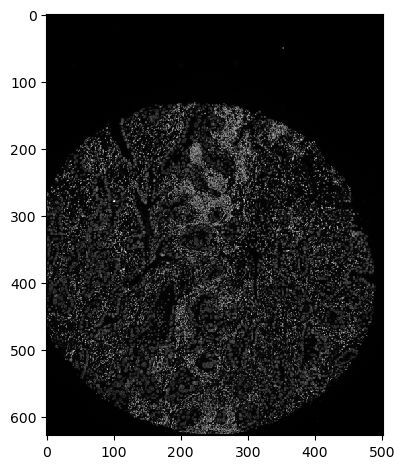

In [40]:
io.imshow(img_downscaled[0].compute())

In [41]:
io.imsave("/Volumes/RD_Coscia/Jose/Resources/TestDatasets/TD_03_Exemplar001_downscaled.ome.tif", img_downscaled.compute())

In [43]:
img

dask.array<_map_read_frame, shape=(12, 3139, 2511), dtype=uint16, chunksize=(1, 3139, 2511), chunktype=numpy.ndarray>

In [ ]:
image = tifffile.imread(path_to_image)

In [2]:
#ok bigimage
HE = imread.imread("/Volumes/Extreme SSD/P26_BCCN/P26_HE_staining/240624_SF_P26_mDVP_991_HE.ome.tiff")

In [3]:
HE = da.squeeze(HE)
HE = HE.transpose(2, 0, 1)
HE = HE.rechunk(chunks=(1, 10000, 10000))

In [4]:
HE_10 = downscale_dask(HE, factors=(1, 0.01, 0.01))

In [ ]:
io.imsave("/Volumes/Extreme SSD/P26_BCCN/P26_HE_staining/240624_SF_P26_mDVP_991_HE_downscaled.ome.tiff", HE_10.compute())